# Download Process

These notebooks contain information about querying and downloading data of the Sentinel-2 mission from the Copernicus Open Access Hub.

```{note}
In order to run these notebooks, a free account for the Copernicus Open Access Hub is needed.
Please create an account first:

https://scihub.copernicus.eu/dhus/#/self-registration

Consult the [README](../README.md) for information on setting up the environment variables.
```

In [1]:
import os
from sentinelsat import SentinelAPI, read_geojson
from tqdm.notebook import tqdm

api = SentinelAPI(os.getenv('SCIHUB_USERNAME'), os.getenv('SCIHUB_PASSWORD'))
api._tqdm = tqdm # ← gives us better progress bars

## Defining the Region of Interest

The Copernicus Open Access Hub API expects a point or area that designates the region of interest.
The [OpenStreetMap Nominatim API](https://nominatim.org/) provides a HTTP-based interface to the OpenStreetMap data set, which can be queried for the administrative boundaries of Berlin.The `search_osm` function defined in `sentinel_helpers.py` allows retrieving these geometries by location name:

In [2]:
from sentinel_helpers import search_osm
??search_osm

Signature: search_osm(place)
Source:   
def search_osm(place):
    '''
    Returns a GeoDataFrame with results from OpenStreetMap Nominatim for the given search string.
    '''
    urlescaped_place = urllib.parse.quote(place)
    search_url = ('https://nominatim.openstreetmap.org/search/?q={}' +
                  '&format=geojson&polygon_geojson=1').format(urlescaped_place)
    return gpd.read_file(search_url)
File:      ~/sources/sentinel_helpers.py
Type:      function


The function is mostly concerned with constructing the correct URL and ensuring that the response is returned as GeoJSON so it can be parsed by the `GeoPandas` library.

A query returns a `GeoPandas` `GeoDataFrame` which contains a geometry and additional information that can be used to narrow down the area of interest in:

In [3]:
results = search_osm('Berlin, Germany')
results.head()

,place_id,osm_type,osm_id,display_name,place_rank,category,type,importance,icon,geometry
0,574401,node,240109189,"Berlin, 10117, Deutschland",15,place,city,0.897539,https://nominatim.openstreetmap.org/ui/mapicon...,POINT (13.38886 52.51704)
1,256375666,relation,62422,"Berlin, Deutschland",8,boundary,administrative,0.897539,https://nominatim.openstreetmap.org/ui/mapicon...,"MULTIPOLYGON (((13.08835 52.41963, 13.09021 52..."
2,1253688,node,313826576,"Berlin, Tauentzienstraße, Charlottenburg, Char...",30,tourism,artwork,0.315372,https://nominatim.openstreetmap.org/ui/mapicon...,POINT (13.33864 52.50340)
3,225671,node,50798110,"Berlin, Seedorf, Trave-Land, Segeberg, Schlesw...",19,place,village,0.272651,https://nominatim.openstreetmap.org/ui/mapicon...,POINT (10.44613 54.03636)
4,107621118,way,68276545,"Berlin, Potsdam, Klein Bennebek, Kropp-Stapelh...",26,highway,unclassified,0.210000,None,"LINESTRING (9.41929 54.40283, 9.42072 54.40343..."


OpenStreetMap contains geoinformation at vastly different scales and of very different types, which range from outlines of parks to entire countries.
The [OpenStreetMap wiki](https://wiki.openstreetmap.org/wiki/Main_Page) contains exhaustive information about the architectural design of OpenStreetMap.
This empowers the `search_osm` function to retrieve geoinformation on places that would otherwise be widely scattered across a myriad of sources, if available at all.

The first result is the city's centroid.
The property listed in the `type` column can be used to select the administrative boundaries.

<AxesSubplot:>

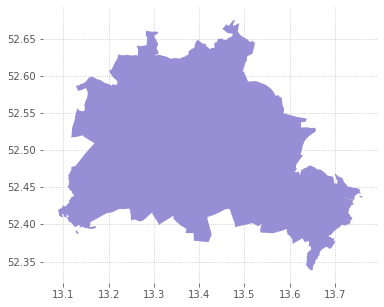

In [4]:
berlin = results[results['type'] == 'administrative']
berlin.plot(figsize=(6,6))

… and save this result for later. All downloaded files as well as all the artifacts generated by the various notebooks will live inside the `resources` directory:

In [5]:
from pathlib import Path

resources = Path('resources')
resources.mkdir(exist_ok=True)
berlin.to_file(resources / 'berlin.geojson', driver='GeoJSON')

OpenStreetMap provides detailed geometries not only for cities, but also for larger areas such as federal states:

<AxesSubplot:>

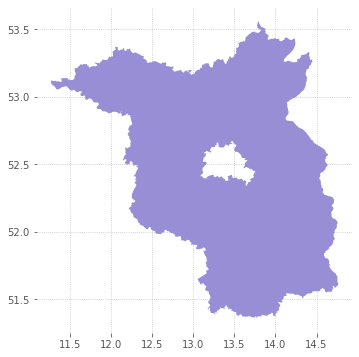

In [6]:
brandenburg = search_osm('Brandenburg, Germany')
brandenburg.iloc[:1].plot(figsize=(6,6))

… or smaller areas such as parks:

<AxesSubplot:>

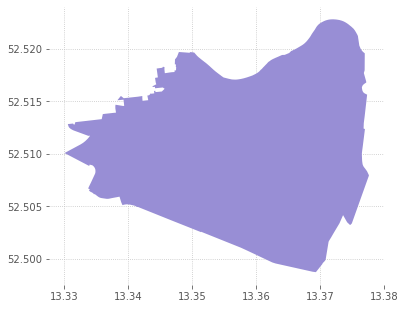

In [7]:
tiergarten = search_osm('Tiergarten, Berlin, Germany')
tiergarten.plot(figsize=(6,6))

In addition to the [OpenStreetMap Wiki](https://wiki.openstreetmap.org/) the [OpenStreetMap Website](https://openstreetmap.org/) is useful to interactively test out different search queries.

We continue with `berlin`.

## Defining a Request to the Copernicus Open Access Hub

An API request additionally contains the time span in which to search for results - so especially recent imagery or imagery over a long time can be directly queried - and the maximum cloud coverage.
The maximum cloud coverage is needed because Sentinel-2 is equipped with optical instruments.
If there are too many clouds the products will not contain a lot of useful information.

In [8]:
from datetime import date
import datetime

# note that start_date are python date objects this means they can be
# manipulated using python functions
start_date = date(2020, 5, 22) 
end_date = date(2020, 6, 22) 
cloud_coverage = (0,30) # between 0 and 30 percent

The region of interest is given as the `footprint` parameter.
The geometry retrieved from OpenStreetMap is simplified by calculating convex hull due to restrictions in URL lengths that don't allow querying for arbitrarily detailed geometries:

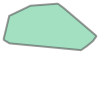

In [9]:
footprint = berlin.iloc[0]['geometry'].convex_hull
footprint

In [10]:
products = api.query(footprint,
                     platformname='Sentinel-2',
                     processinglevel='Level-2A',
                     date=(start_date, end_date),
                     cloudcoverpercentage=cloud_coverage)

print(f'Found {len(products)} results')

Found 16 results


## Selecting Products from the Result Set

The criteria for selecting a product depends on the specific use case.
The first use case is to plot an image of Berlin, so as much of the city as possible should be visible in the downloaded data.

The list of products to a `GeoDataFrame` (`gdf`):

In [11]:
gdf = api.to_geodataframe(products)

/opt/conda/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


`plot_product_extent` allows plotting the tile geometry of downloaded or available products over with a designated area of interest.

This provides quick visual impression of the result:

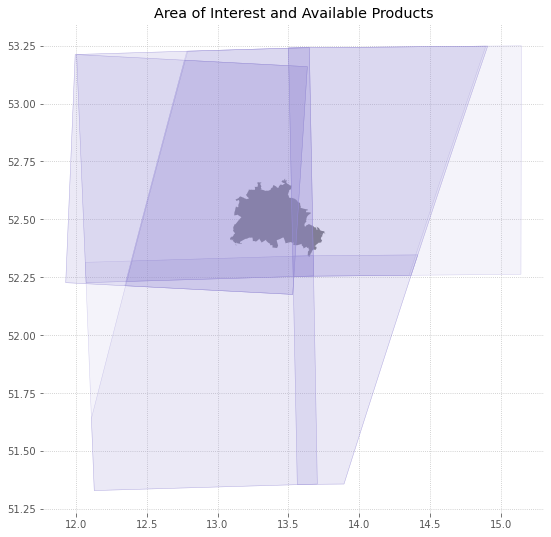

In [12]:
from sentinel_helpers import plot_product_extent
ax = plot_product_extent(gdf, berlin, figsize=(9,9))

```{note}
The geometrical shape of the captured data depends on where the Sentinel-2 satellite was in orbit when it crossed the area of interest.
For an in-depth analysis see [](01c-coverage-analysis.ipynb)</code>.
```

Because products are large (roughly 1GB), it is desirable to skip unnecessary downloads whenever possible.
Products are therefore filtered by two criteria:

- How much of the area of interest is visible in the product (i.e. area of the intersection of a product's tile and the area of interest)
- Cloud coverage (the less the better)

In [13]:
# we are using a metric coordinate reference system for europe in order to
# safely compare areas 
gdf = gdf.to_crs('EPSG:4839')
berlin = berlin.to_crs('EPSG:4839')

In [14]:
import geopandas as gpd

intersection = gpd.overlay(
    gdf,
    berlin,
    how="intersection"
)
intersection['area'] = intersection['geometry'].area
max_area = max(*intersection['area'])

largest_intersections = intersection[intersection['area'] == max_area]
largest_intersections

,title,link,link_alternative,link_icon,summary,ondemand,beginposition,endposition,ingestiondate,orbitnumber,...,osm_type,osm_id,display_name,place_rank,category,type,importance,icon,geometry,area
1,S2A_MSIL2A_20200617T101031_N0214_R022_T33UUU_2...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,"Date: 2020-06-17T10:10:31.024Z, Instrument: MS...",false,2020-06-17 10:10:31.024,2020-06-17 10:10:31.024,2020-06-17 21:35:56.836,26045,...,relation,62422,"Berlin, Deutschland",8,boundary,administrative,0.897539,https://nominatim.openstreetmap.org/ui/mapicon...,"MULTIPOLYGON (((215331.937 168288.512, 216047....",8.535962e+08
3,S2B_MSIL2A_20200615T101559_N0214_R065_T33UUU_2...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,"Date: 2020-06-15T10:15:59.024Z, Instrument: MS...",false,2020-06-15 10:15:59.024,2020-06-15 10:15:59.024,2020-06-16 01:21:09.378,17108,...,relation,62422,"Berlin, Deutschland",8,boundary,administrative,0.897539,https://nominatim.openstreetmap.org/ui/mapicon...,"MULTIPOLYGON (((215331.937 168288.512, 216047....",8.535962e+08
10,S2B_MSIL2A_20200602T100559_N0214_R022_T33UUU_2...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,"Date: 2020-06-02T10:05:59.024Z, Instrument: MS...",false,2020-06-02 10:05:59.024,2020-06-02 10:05:59.024,2020-06-02 18:40:43.331,16922,...,relation,62422,"Berlin, Deutschland",8,boundary,administrative,0.897539,https://nominatim.openstreetmap.org/ui/mapicon...,"MULTIPOLYGON (((215331.937 168288.512, 216047....",8.535962e+08
11,S2A_MSIL2A_20200531T102031_N0214_R065_T33UUU_2...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,https://scihub.copernicus.eu/apihub/odata/v1/P...,"Date: 2020-05-31T10:20:31.024Z, Instrument: MS...",false,2020-05-31 10:20:31.024,2020-05-31 10:20:31.024,2020-05-31 20:21:27.279,25802,...,relation,62422,"Berlin, Deutschland",8,boundary,administrative,0.897539,https://nominatim.openstreetmap.org/ui/mapicon...,"MULTIPOLYGON (((215331.937 168288.512, 216047....",8.535962e+08


In [15]:
largest_intersections[['title', 'cloudcoverpercentage']]

,title,cloudcoverpercentage
1,S2A_MSIL2A_20200617T101031_N0214_R022_T33UUU_2...,24.374344
3,S2B_MSIL2A_20200615T101559_N0214_R065_T33UUU_2...,3.626466
10,S2B_MSIL2A_20200602T100559_N0214_R022_T33UUU_2...,0.345483
11,S2A_MSIL2A_20200531T102031_N0214_R065_T33UUU_2...,16.512980


These files will all be downloaded to `resources/true_color_image`.
Repeated calls to `download` or `download_all` will skip the download process if a product has previously been downloaded.

In [16]:
dst_path = resources / 'true_color_image'
# we make sure to create the directory at dst_path so the notebook can run
# without interruptions
dst_path.mkdir(exist_ok=True, parents=True)

downloads, _, _ = api.download_all(largest_intersections['uuid'].values, dst_path)
downloads

{'958ef7fc-815e-47c6-b323-219de6a91339': {'id': '958ef7fc-815e-47c6-b323-219de6a91339',
  'title': 'S2A_MSIL2A_20200617T101031_N0214_R022_T33UUU_20200617T161854',
  'size': 854267363,
  'md5': 'E8E78FEEBF25D95E50A7E5E0C971C061',
  'date': datetime.datetime(2020, 6, 17, 10, 10, 31, 24000),
  'footprint': 'POLYGON((12.352510548540328 52.23126993496904,12.408603762795623 52.36271559980042,12.470993716931147 52.50836314366547,12.533637922787934 52.653880456978825,12.596456783078388 52.79937966494399,12.659608391506955 52.944876790325615,12.72334134983589 53.09033052896263,12.783072077326212 53.2261774473976,13.648341514492438 53.24196354764364,13.678544065009483 52.25515074878083,12.352510548540328 52.23126993496904))',
  'url': "https://scihub.copernicus.eu/apihub/odata/v1/Products('958ef7fc-815e-47c6-b323-219de6a91339')/$value",
  'Online': True,
  'Creation Date': datetime.datetime(2020, 6, 17, 21, 36, 46, 539000),
  'Ingestion Date': datetime.datetime(2020, 6, 17, 21, 35, 56, 836000),


`downloads` contains a dictionary, mapping each product's UUID to detailed information about the downloaded product.
This information can be used to calculate the total download size:

In [17]:
downloaded_bytes_total = sum(p['size'] for p in downloads.values())
print(f'Downloaded {(downloaded_bytes_total / 1024 ** 3):.2f}GB')

Downloaded 3.78GB
